# Deep Learning Project

### Loading the pre-requisites

Importing the modules.

In [1]:
# from google.colab import drive
import os
from glob import glob
import random
random.seed(2708)
import math
import json
import numpy as np
np.random.seed(2708)
import cv2
import matplotlib.pyplot as plt
import importlib
# Verifying is pydicom is downloaded
if importlib.util.find_spec("pydicom") is None:
  !pip install pydicom
import pydicom

Mounting the drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Defining the data path and unzipping the data.

In [ ]:
!unzip -q '/content/drive/MyDrive/DL_Project_Data/triplets.zip' -d '/content/DL_Project_Data/'

### Data pre-processing and visualiation

Creating a function to load, pre-process and generate 3 representations from a DICOM example.

In [2]:
def convert_file_to_3channel(dcm_path, toImageNet=False, output_size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Loading the file data
    ds = pydicom.dcmread(dcm_path)
    # Loading the pixel values
    img = ds.pixel_array.astype(np.float32)
    # Converting to Hounsfield Units (HU)
    intercept = float(ds.RescaleIntercept)
    slope = float(ds.RescaleSlope)
    hu = img * slope + intercept
    # Defining the window presets
    # brain, subdural and bone
    windows = [(40, 80), (80, 200), (600, 2800)]
    # Windowing the images according to the three presets
    channels = []
    for center, width in windows:
        mn = center - width // 2
        mx = center + width // 2
        win = np.clip(hu, mn, mx)
        # Normalizing to [0, 1]
        norm = (win - mn) / (mx - mn)
        # Resizing to the output size
        if toImageNet:
            resized = cv2.resize(norm, output_size, interpolation=cv2.INTER_LINEAR)
        channels.append(resized)
    # Stacking into (3, H, W)
    three_chan = np.stack(channels, axis=0).astype(np.float32)
    # Applying ImageNet normalization
    if toImageNet:
        mean_values = np.array(mean, dtype=np.float32).reshape(3, 1, 1)
        std_values = np.array(std, dtype=np.float32).reshape(3, 1, 1)
        three_chan = (three_chan - mean_values) / std_values
    return three_chan

Creating a function to view all the 3 channels for multiple triplets.

In [3]:
def display_triplets(triplets_data, triplets_per_row=4):
    # Calculating the number of rows and columns needed
    num_triplets = len(triplets_data)
    num_rows = math.ceil(num_triplets/triplets_per_row)
    # Plotting for each row
    for row_number in range(num_rows):
        row_triplets_data = triplets_data[row_number*triplets_per_row:(row_number+1)*triplets_per_row]
        fig, axes = plt.subplots(3, triplets_per_row*3, figsize=(triplets_per_row * 7.5, 7.5))
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        # Sweeping over all the row triplet data
        for i, triplet in enumerate(row_triplets_data):
            triplet_slices = triplet['slices']
            triplet_label = triplet['label']
            # Calculating the triplet's position in the grid
            triplet_col = i % triplets_per_row
            # Looping over each triplet
            for slice_idx in range(3):
                dcm_path = triplet_slices[slice_idx]
                # Processing the DICOM file to get 3 channels
                three_chan_img = convert_file_to_3channel(dcm_path, toImageNet=True)
                # Viewing the three channels per slice
                for channel_idx in range(3):
                    # Viewing the data
                    ax = axes[slice_idx, triplet_col * 3 + channel_idx]
                    ax.imshow(three_chan_img[channel_idx, :, :])
                    if slice_idx == 0 and channel_idx == 1:
                        ax.set_title(f'|--------------Label: {triplet_label}--------------|', fontsize=20, pad=10)
                    ax.axis('off')
        plt.show()


Visualizing all the three channels for one triplet per class

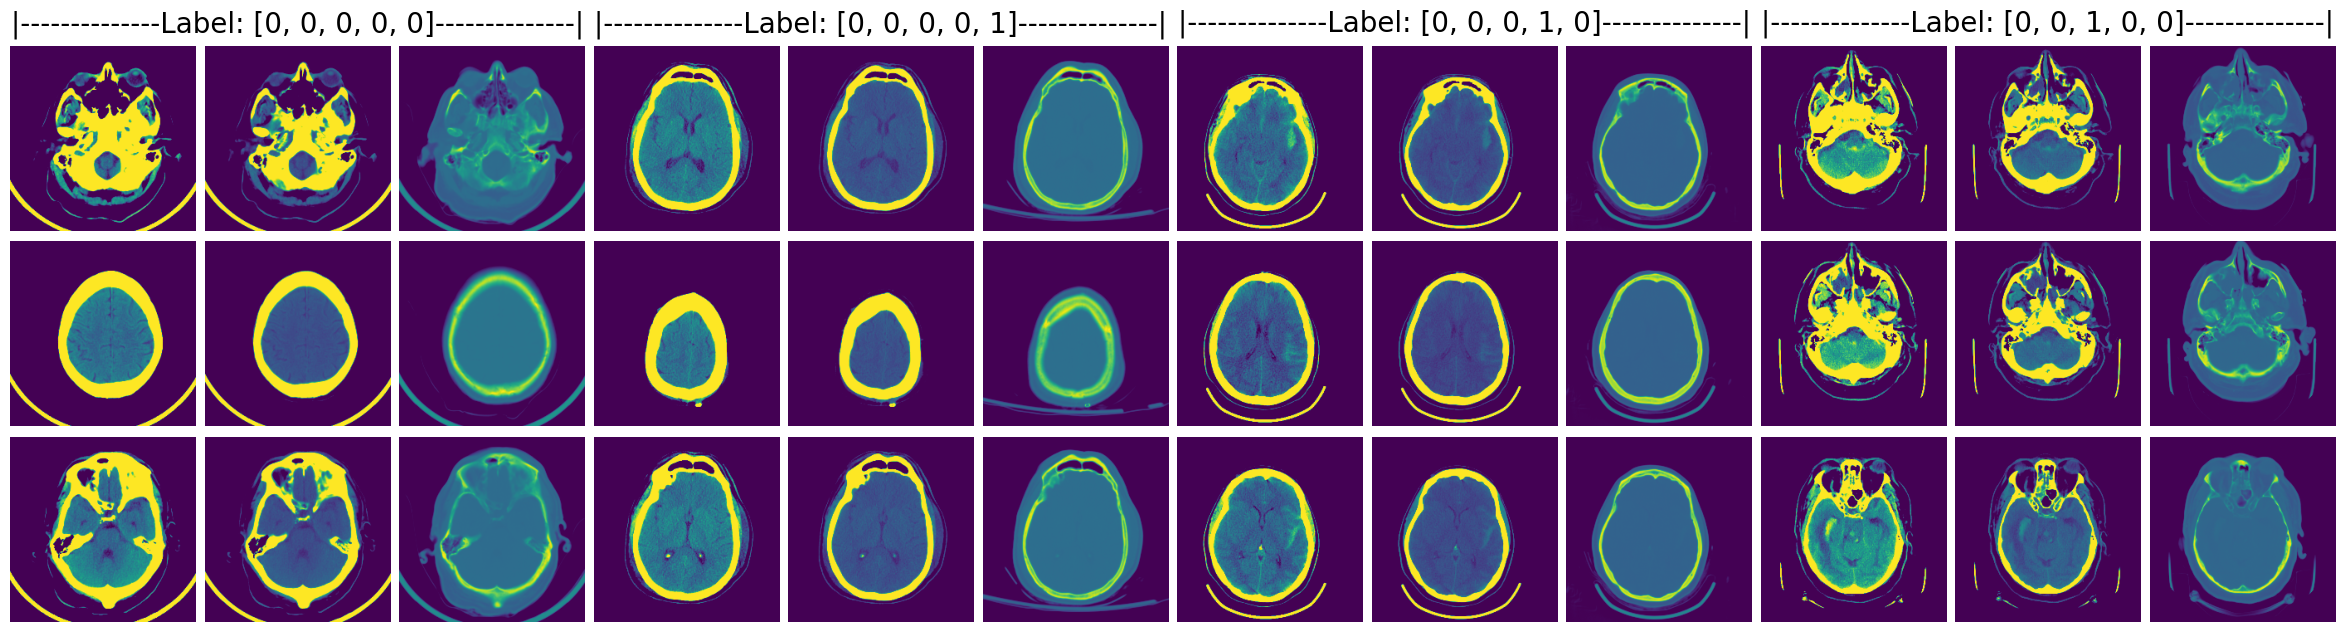

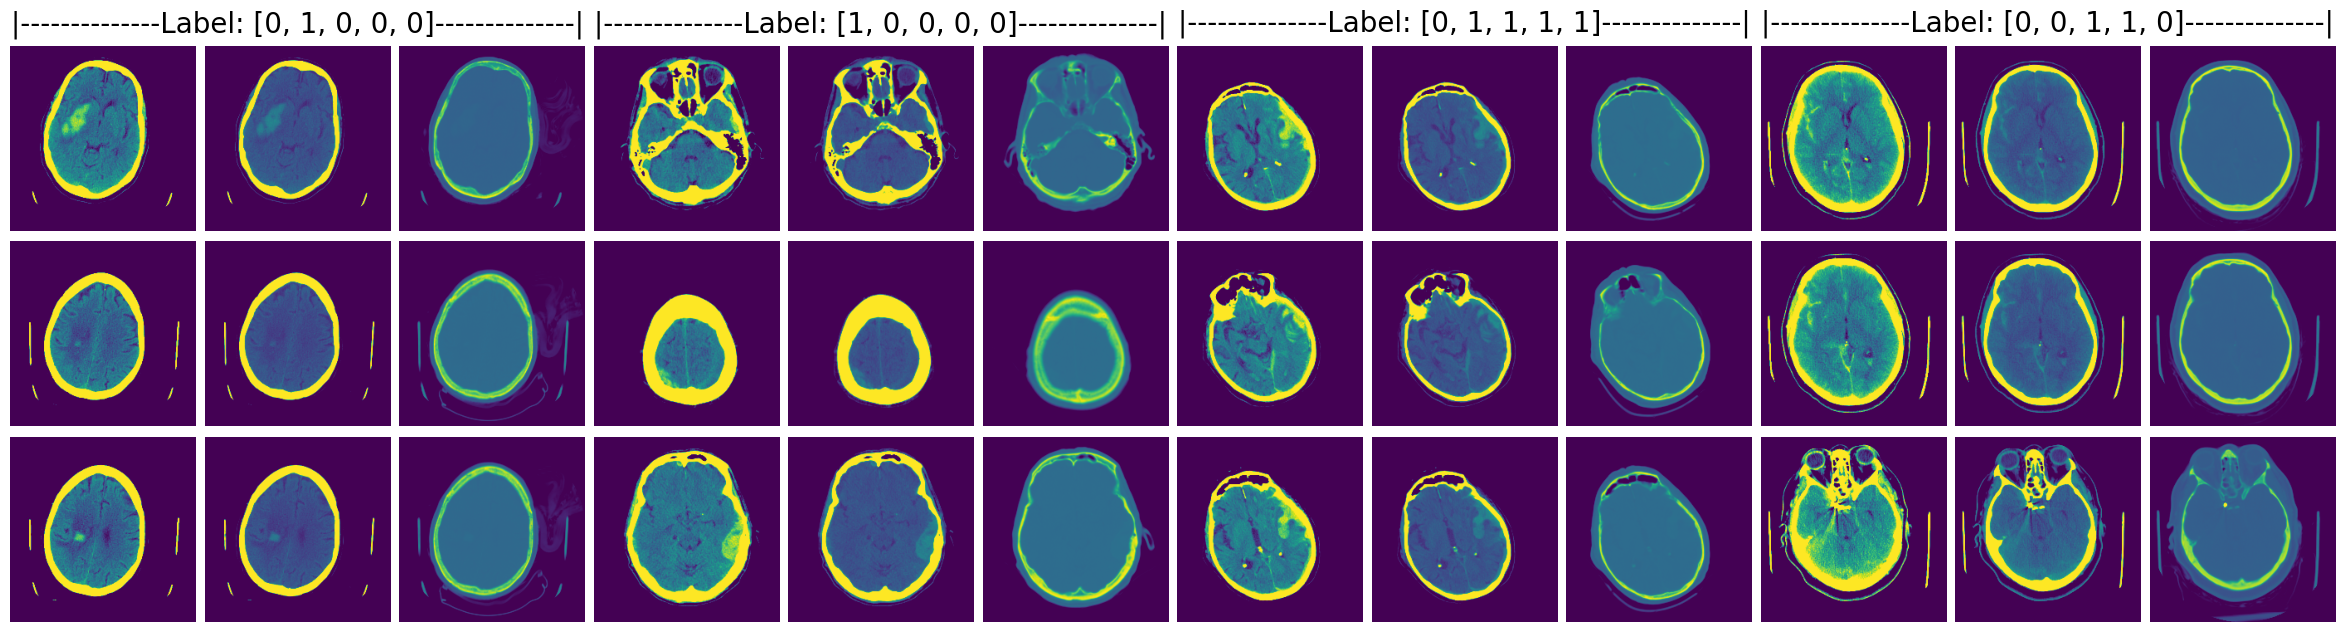

In [4]:
data_dir = 'triplets'
with open('triplets/labels.json', 'r') as f:
    data_label = json.load(f)
triplets_data = []

# Listing all folders in the data directory
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
folders = sorted(folders)
# As we want two examples from the multiple class
folders.append(folders[-1])

# Looping over each folder
for folder_name in folders:
    folder_path = os.path.join(data_dir, folder_name)
    # Listing all the sub-folder in the folder
    sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    # Randomly choosing a sub-folder
    selected_sub_folder = random.choice(sub_folders)
    # Taking the files from the chosen sub-folder
    selected_files = os.listdir(os.path.join(folder_path, selected_sub_folder))
    # Extracting the label
    label = data_label[selected_sub_folder]
    # Placing the selected data in a dictionary
    triplet_dict = {
        'slices': [os.path.join(folder_path, selected_sub_folder, f) for f in selected_files],
        'label': label
    }
    # Appendin the dictionary to the list
    triplets_data.append(triplet_dict)

# Visualizing the results
display_triplets(triplets_data, triplets_per_row=4)